## 1. 实战Kaggle比赛：预测房价
实现几个函数方便下载数据


In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的`download`函数用来下载数据集，
将数据集缓存在本地目录（默认情况下为`../data`）中，
并返回下载文件的名称。
如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在`DATA_HUB`中的相匹配，
我们将使用缓存的文件，以避免重复的下载。


In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还需实现两个实用函数：
一个将下载并解压缩一个zip或tar文件，
另一个是将本书中使用的所有数据集从`DATA_HUB`下载到缓存目录中。


In [5]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## 使用```pandas```读入并处理数据

In [6]:
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

为方便起见，我们可以使用上面定义的脚本下载并缓存Kaggle房屋数据集。


In [7]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [8]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [11]:
# 打印样本
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


训练及包含1460个样本，80个特征和一个标号， 测试集没有标号，总共80个特征

## 前四个和最后两个特征，已经相应标签（房价）

In [25]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


## 在每个样本中，第一个特征是ID，我们将其删除

In [26]:
# 训练数据删除第一列和最后一列
# 测试集删除第一列
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))


## 数据处理
将所有缺失的值替换为相应特征的平均值，通过将特征重新缩放到零均值和单位方差来标准化数据

In [43]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失(为0)，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

## 处理离散值，我们用一次独热（one-hot）编码替换他们

In [51]:
print('all_features.shape: ', all_features.shape)
all_features = pd.get_dummies(all_features, dummy_na=True)
print('all_features.shape after one-hot: ', all_features.shape) 
all_features.columns

all_features.shape:  (2919, 331)
all_features.shape after one-hot:  (2919, 331)


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleType_nan', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=331)

从```pandas```格式提取NumPy格式，并将其转换为张量表示

In [77]:
n_train = train_data.shape[0]

train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

print(train_labels.shape)

torch.Size([1460, 1])


## 训练

In [159]:
# loss = nn.MSELoss()
# in_features = train_features.shape[1]
# def get_net():
#     net = nn.Sequential(nn.Linear(in_features, 1))
#     return net
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    # net = nn.Sequential(nn.Linear(in_features,64), nn.ReLU(), nn.Linear(64, 12), nn.ReLU(), nn.Linear(12, 1))
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

## 优化损失函数
我们更关心相对误差$\frac{y - \hat{y}}{y}$, 解决这个问题的一种方式是对价格预测的对数来衡量差异

In [115]:
def log_rmse(net, features, labels):
    # 将 'inf'变为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # 将预测和label都取log
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

# def log_rmse(net, features, labels):
#     # 为了在取对数时进一步稳定该值，将小于1的值设置为1
#     clipped_preds = torch.clamp(net(features), 1, float('inf'))
#     rmse = torch.sqrt(loss(torch.log(clipped_preds),
#                            torch.log(labels)))
#     return rmse.item()

## 我们的训练函数将借助Adam优化器

In [176]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    # print(f'Load array, {train_features.shape}, {train_labels.shape}')
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # optimizer = torch.optim.SGD([{
    #     "params": net[0].weight,
    #     'weight_decay': 6}, {"params": net[0].bias}], lr=learning_rate)
    # optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            # print(f'X.shape: {X.shape} y.shape: {y.shape}')
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls
                                

## 实现K折交叉验证

In [168]:
def get_k_fold_data(k, i, X, y):
    """
    i 是当前第几折
    """
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None

    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            # 验证集
            X_valid, y_valid = X_part, y_part
            
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid



## 返回训练和验证误差的平均值

In [169]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # print(f'K fold, X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], 
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}', 
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择

train_labels torch.Size([1460, 1])
fold 1, train log rmse 0.138857 验证log rmse0.143409
fold 2, train log rmse 0.135397 验证log rmse0.150738
fold 3, train log rmse 0.133730 验证log rmse0.145168
fold 4, train log rmse 0.139548 验证log rmse0.137120
fold 5, train log rmse 0.131536 验证log rmse0.167381
5-折验证: 平均训练log rmse: 0.135814, 平均验证log rmse: 0.148763


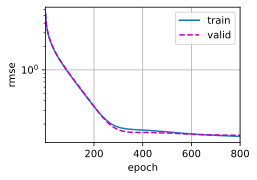

In [184]:
# k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
# train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
lr = 1e-3
print(f'train_labels {train_labels.shape}')
k, num_epochs, lr, weight_decay, batch_size = 5, 800, 1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 提交Kaggle预测

train log rmse 0.033487


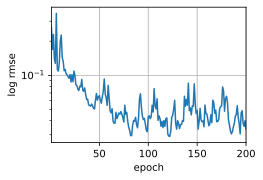

In [145]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    
    d2l.plot(np.arange(1, num_epochs +1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)